In [14]:
import mxnet as mx
mnist = mx.test_utils.get_mnist()
batch_size = 100
train_iter = mx.io.NDArrayIter(mnist['train_data'], mnist['train_label'], batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)

data = mx.sym.var('data')
data = mx.sym.flatten(data=data)

fc1 = mx.sym.FullyConnected(data=data, num_hidden=128)
act1 = mx.sym.Activation(data=fc1, act_type='relu')

fc2 = mx.sym.FullyConnected(data=act1, num_hidden=64)
act2 = mx.sym.Activation(data=fc2, act_type='relu')

fc3 = mx.sym.FullyConnected(data=act2, num_hidden=10)
mlp = mx.sym.SoftmaxOutput(data=fc3, name='softmax')

import logging
logging.getLogger().setLevel(logging.DEBUG)

mlp_model = mx.mod.Module(symbol=mlp, context=mx.cpu())
mlp_model.fit(train_iter, eval_data=val_iter, optimizer='sgd',
  optimizer_params={'learning_rate': 0.1}, eval_metric='acc',
  batch_end_callback = mx.callback.Speedometer(batch_size, 100),
  num_epoch=10)

INFO:root:train-labels-idx1-ubyte.gz exists, skipping download
INFO:root:train-images-idx3-ubyte.gz exists, skipping download
INFO:root:t10k-labels-idx1-ubyte.gz exists, skipping download
INFO:root:t10k-images-idx3-ubyte.gz exists, skipping download
INFO:root:Epoch[0] Batch [100]	Speed: 29618.28 samples/sec	accuracy=0.106634
INFO:root:Epoch[0] Batch [200]	Speed: 36891.29 samples/sec	accuracy=0.114000
INFO:root:Epoch[0] Batch [300]	Speed: 28047.50 samples/sec	accuracy=0.110900
INFO:root:Epoch[0] Batch [400]	Speed: 32867.42 samples/sec	accuracy=0.113500
INFO:root:Epoch[0] Batch [500]	Speed: 31111.65 samples/sec	accuracy=0.147700
INFO:root:Epoch[0] Train-accuracy=0.339495
INFO:root:Epoch[0] Time cost=1.916
INFO:root:Epoch[0] Validation-accuracy=0.458000
INFO:root:Epoch[1] Batch [100]	Speed: 32256.85 samples/sec	accuracy=0.497822
INFO:root:Epoch[1] Batch [200]	Speed: 34271.45 samples/sec	accuracy=0.677100
INFO:root:Epoch[1] Batch [300]	Speed: 36789.37 samples/sec	accuracy=0.772500
INFO:roo

In [15]:
test_iter = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)
acc = mx.metric.Accuracy()
mlp_model.score(test_iter, acc)
print(acc)
assert acc.get()[1] > 0.96

EvalMetric: {'accuracy': 0.96960000000000002}


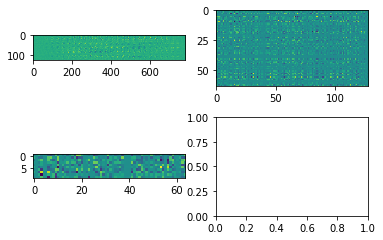

In [70]:
import matplotlib.pyplot as plt
axes = plt.subplots(2, 2)[1]
for axis, sym in zip(axes.flatten(), [fc1, fc2, fc3]):
  weights = mlp_model._arg_params[sym.name + '_weight'].asnumpy()
  axis.imshow(weights)
plt.show()

In [126]:
from midiutil.MidiFile import MIDIFile

weights = mlp_model._arg_params[fc1.name + '_weight'].asnumpy()
print("Shape:", weights.shape)

bpm = 120
volume = 100
note_range = [36, 107]  # C3 - B8
midi = MIDIFile(1)     # 1 track

midi.addTrackName(0, 0, 'fc3 Track')
midi.addTempo(0, 0, bpm)

print("Converting")
for i, notes in enumerate(weights):  # Weights for every node in left layer to right layer.
  time = int(bpm * i / 20) / 60
  duration = int(bpm * 0.2) / 60
  pitches = np.linspace(0, 1, weights.shape[0]) * (note_range[1] - note_range[0]) + note_range[0]
  pitches = pitches.astype(np.int8)
  for weight, pitch in zip(notes, pitches):
    weight += 0.2  # only for fc1
    if weight < 0.25 or weight > 1.0: continue
    midi.addNote(0, 0, pitch, time, duration, int(volume * weight))

print("Writing")
with open('out.mid', 'wb') as fp:
  midi.writeFile(fp)

Shape: (128, 784)
Converting
Writing


/home/niklas/.local/share/virtualenvs/Neural_Net_MNIST-2TKtyscG/lib/python3.6/site-packages/midiutil/MidiFile.py:899: FutureWarning: Please explicitly set adjust_origin. Default behaviour will change in a future version.
  FutureWarning)
